# Comparison of reference matching algorithms

Dominika Tkaczyk

22.11.2018

This file contains the comparison of the following approaches to bibliographic reference matching:
  * **STQ**: the currently used matching approach
  * **SBM** and **SBMV**: search-based matching

**STQ** is Crossref's current matching algorithm. STQ internally uses a 3rd party parser and regular expressions and queries the Oracle. I run this matching algorithm using [Simple Text Query form](https://apps.crossref.org/SimpleTextQuery/).

**SBM** (Search-Based Matching) is a new idea, based on the search functionality of Crossref REST API. It is a very simple algorithm, which doesn't include any reference parsing step. In SBM the entire reference string is used as a search query in REST API. The first hit is returned as the matched target document, if its relevance score is high enough. If the relevance score of the first hit is low, no target DOI is assigned and the reference string stays unmatched.

**SBMV** (Search-Based Matching with Validation) is a variation of SBM, in which we use additional validation procedure on top of SBM. In SBMV, "simple" SBM is first applied and a number of top search results are selected as candidate target documents. Second, during the validation the candidates are re-scored based on the validation similarity between the input string and the candidates. This validation similarity is based on the presence of the candidate's metadata fields (year, volume, issue, pages, the lastname of the first author, etc.) in the input reference string, as well as the relevance score returned by the search engine. Finally, the most similar candidate is chosen as the final target document, if its similarity is high enough. If the highest similarity is low, null value is returned and the reference string stays unmatched.

The goal of this analysis is to evaluate and compare these matching algorithms.

## TL;DR

  * A large automatically generated dataset was used for the experiments. It is composed of 7374 real metadata records, each of which was formatted automatically into reference strings using 11 citation styles.
  * The main metrics used for the evaluation are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall). I also use [F1](https://en.wikipedia.org/wiki/F1_score) as a standard metric that combines precision and recall into a single number, weighing them equally.
  * Three variations of search-based matching were tested and compared against STQ (more about the thresholds and how their values were calculated can be found [here](https://github.com/CrossRef/reference-matching-evaluation/blob/master/analyses/relevance_threshold.ipynb)):
    * SBM with a simple relevance threshold of 54
    * SBM with a normalized relevance threshold of 0.47
    * SBMV with a normalized threshold of 0.4 and a validation threshold of 0.56
  * All variations of SBM(V) outperform STQ on the automatically generated dataset:
    * SBM with a simple threshold: F1 81.4% vs. 57.1%
    * SBM with a normalized threshold: F1 86.4% vs. 57.1%
    * SBMV: F1 87.9% vs. 57.1%
  * **The best approach is SBMV**:
    * **SBMV performs roughly the same as STQ in precision** (99.3% vs. 99.3%)
    * **SBMV is much better than STQ in recall** (83.1% vs. 45.4%, this difference is statistically significant)
  * SBM with a simple threshold outperforms STQ in 8 citation styles out of 11. SBM with a normalized threshold and **SBMV outperform STQ in all 11 citation styles**.
  * Weak spot of STQ are degraded/noisy reference strings, which do not appear to use any of the known citation style.
  * Weak spot of SBM(V) are short reference strings, and in particular citation styles that do not include the title in the string.

## Methodology

### The algorithms

Four algorithms were compared in this experiment:
* STQ
* SBM with a simple relevance threshold of 54
* SBM with a normalized relevance threshold of 0.47
* SBMV with a normalized relevance threshold of 0.4 and a similarity threshold of 0.56

The threshold values used here are the best values calculated in a separate [analysis](https://github.com/CrossRef/reference-matching-evaluation/blob/master/analyses/relevance_threshold.ipynb).

### The dataset

The dataset used for the experiments was generated automatically using the following workflow.

First, I took a sample of 2500 items from the system. (This number was chosen as big enough to give reliable results and small enough to handle the current STQ form limits.) To eliminate items with very poor metadata, the sample was randomly selected from a subset of items, for which at least one of the following conditions is true:
  * it has at least three out of the following metadata fields: authors, title, year, volume, pages
  * it has authors and year
  * it has title and year

Second, I extended the sample by adding up to 2 similar documents for each item in the sample. Similar documents were found by selecting the highest hits from the search results. As a search query I used the concatenation of the title, container title and family names of all the authors. This step was performed to increase the probability of incorrect links pointing to the base sample (i.e. to have a non-zero false positive rate). Extending the dataset resulted in 7498 items in total (fewer than 3 x the original sample size, because for some documents fewer than 2 similar documents could be found).

Next, reference strings were generated for all items. In this experiment, I used the following 11 styles:
  * popular styles:
    * **american-chemical-society**
    * **american-institute-of-physics**
    * **elsevier-without-titles**
    * **apa**
    * **chicago-author-date**
    * **modern-language-association**
  * popular styles + random noise added to the reference strings (additional spaces, missing spaces, typos):
    * **apa+noise**
    * **american-institute-of-physics+noise**
  * custom "styles":
    * **degraded_all_authors**: a simple concatenation of authors' names, title, container title, year, volume, issue and pages
    * **degraded_one_author**: a simple concatenation of the first author's name, title, container title, year, volume, issue and pages
    * **degraded_title_scrambled**: same as degraded_all_authors, but with the title words randomly shuffled

Finally, each string was passed to all reference matching algorithms and the returned matched DOIs were recorded. For SBM and SBMV I also kept the resulting relevance/similarity scores, so that it is possible to later apply any threshold.

Note that this workflow is automatic, but it resembles what a lot of authors do when they compile the bibliographies for their papers (finding the metadata of the cited paper in a digital repository, and using a tool to format the metadata into a specified citation style). As a result, even though the reference strings we have in the dataset are not strings we actually came across in the live system, these are strings that could easily appear there. 

### The metrics


To evaluate and compare the algorithms, I used averaged document-based metrics. More specifically, for each document from the base sample the following metrics are calculated:
  * **precision**: what fraction of links to document X returned by the matching algorithm are correct (or: what is the probability that the link to document X returned by the algorithm is correct)
  * **recall**: what fraction of true expected links to document X were returned by the algorithm (or: what is the probability that the true link to document X will be returned by the algorithm)
  * **F1**: harmonic mean of precision and recall. F1 is a standard metric, used in information retrieval to combine precision and recall into a single number, weighing them equally. A more generic version of this metric, called F-measure, can be used to place more emphasis on either precision or recall. In these experiments I use a balanced version.

These numbers are then averaged over all 2500 documents from the base sample. The averages can be treated as single-number metrics, and the distributions of the results over the documents allow to calculate the confidence intervals. 

More information about the metrics can be found [here](https://docs.google.com/document/d/1X0clkjH-HM3DLVPWDgAZgS97Th4slniq28F9o-yd53k). More information about the foundations of sampling and confidence intervals can be found in [this notebook](https://github.com/CrossRef/reference-matching-evaluation/blob/master/analyses/sampling_notes.ipynb).

## Results

In [1]:
import sys
sys.path.append('..')

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import re
import utils.data_format_keys as dfk

from evaluation.document_metrics import ByDocumentMetricsResults
from evaluation.split_metrics import SplitByRefAttrResults
from scipy.stats import ttest_rel
from utils.utils import read_json

DATA_DIR = '../data/comparison/'
STYLES = ['american-chemical-society', 'american-institute-of-physics',
          'american-institute-of-physics-noise', 'apa', 'apa-noise', 'chicago-author-date',
          'degraded_all_authors', 'degraded_one_author', 'degraded_title_scrambled',
          'elsevier-without-titles', 'modern-language-association']

Let's first read the data:

In [2]:
def read_data(algorithm):
    dataset = []
    for style in STYLES:
        d = read_json(DATA_DIR + 'matched/matched-' + algorithm + '-' + style + '.json')
        dois = d[dfk.DATASET_DOIS]
        dataset.extend(d[dfk.DATASET_DATASET])
    return dataset, dois

dataset_stq, dois = read_data('stq')
dataset_sbm, _ = read_data('sbm')
dataset_sbmv, _ = read_data('sbmv')
print('STQ dataset size: {}'.format(len(dataset_stq)))
print('SBM dataset size: {}'.format(len(dataset_sbm)))
print('SBMV dataset size: {}'.format(len(dataset_sbmv)))

STQ dataset size: 82478
SBM dataset size: 82478
SBMV dataset size: 82478


*dois* is the list of 2500 DOIs from the original sample. We will need it for the evaluation.

In [3]:
print('Size of the base sample: {}'.format(len(dois)))

Size of the base sample: 2500


Let's first look at the overall averaged results for all the citation styles combined into a single dataset. Here are the results of STQ algorithm:

In [4]:
def print_summary(results, name):
    for av, ci, metric in results.metrics_groups:
        print('Average {} for {} algorithm: {:.4f} (confidence interval (95%): {:.4f} - {:.4f})'
              .format(metric, name, results.get(av), results.get(ci)[0], results.get(ci)[1]))

results_stq = ByDocumentMetricsResults(dataset_stq, dois)
results_style_stq = SplitByRefAttrResults(dataset_stq, 'style', dois)
print_summary(results_stq, 'STQ')

Average precision for STQ algorithm: 0.9931 (confidence interval (95%): 0.9907 - 0.9955)
Average recall for STQ algorithm: 0.4535 (confidence interval (95%): 0.4433 - 0.4636)
Average F1 for STQ algorithm: 0.5708 (confidence interval (95%): 0.5595 - 0.5822)


In order to calculate the results for SBM and SBMV, we have to modify the SBM and SBMV datasets according to the best thresholds calculated previously. These functions will modify the dataset according to the simple, normalized or validation threshold:

In [5]:
def modify_simple_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None and item[dfk.DATASET_SCORE] < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

def modify_norm_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None \
            and item[dfk.DATASET_SCORE]/len(item[dfk.DATASET_REF_STRING]) < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

def modify_valid_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None and item[dfk.DATASET_SCORE] < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

Let's calculate the results for SBM with the best simple threshold of 54:

In [6]:
dataset_sbm, _ = read_data('sbm')
dataset_sbm = modify_simple_threshold(dataset_sbm, 54)
results_sbm_54 = ByDocumentMetricsResults(dataset_sbm, dois)
results_style_sbm_54 = SplitByRefAttrResults(dataset_sbm, 'style', dois)
print_summary(results_sbm_54, 'SBM (t=54)')

Average precision for SBM (t=54) algorithm: 0.9894 (confidence interval (95%): 0.9867 - 0.9920)
Average recall for SBM (t=54) algorithm: 0.7354 (confidence interval (95%): 0.7262 - 0.7446)
Average F1 for SBM (t=54) algorithm: 0.8139 (confidence interval (95%): 0.8054 - 0.8224)


And here we have the results for SBM with the best normalized threshold of 0.47:

In [7]:
dataset_sbm, _ = read_data('sbm')
dataset_sbm = modify_norm_threshold(dataset_sbm, 0.47)
results_sbm_047 = ByDocumentMetricsResults(dataset_sbm, dois)
results_style_sbm_047 = SplitByRefAttrResults(dataset_sbm, 'style', dois)
print_summary(results_sbm_047, 'SBM (tnorm=0.47)')

Average precision for SBM (tnorm=0.47) algorithm: 0.9882 (confidence interval (95%): 0.9855 - 0.9909)
Average recall for SBM (tnorm=0.47) algorithm: 0.8183 (confidence interval (95%): 0.8087 - 0.8280)
Average F1 for SBM (tnorm=0.47) algorithm: 0.8640 (confidence interval (95%): 0.8552 - 0.8728)


Finally, the results for SBMV with the normalized threshold of 0.4 for candidate selection and the validation threshold of 0.56:

In [8]:
dataset_sbmv, _ = read_data('sbmv')
dataset_sbmv = modify_simple_threshold(dataset_sbmv, 0.56)
results_sbmv_056 = ByDocumentMetricsResults(dataset_sbmv, dois)
results_style_sbmv_056 = SplitByRefAttrResults(dataset_sbmv, 'style', dois)
print_summary(results_sbmv_056, 'SBMV (tvalid=0.56)')

Average precision for SBMV (tvalid=0.56) algorithm: 0.9931 (confidence interval (95%): 0.9910 - 0.9952)
Average recall for SBMV (tvalid=0.56) algorithm: 0.8309 (confidence interval (95%): 0.8219 - 0.8400)
Average F1 for SBMV (tvalid=0.56) algorithm: 0.8792 (confidence interval (95%): 0.8712 - 0.8871)


Let's compare the overall results using a single plot:

In [9]:
def get_means(results):
    return [results.get(m) for m in [dfk.EVAL_MEAN_PREC, dfk.EVAL_MEAN_REC, dfk.EVAL_MEAN_F1]]

def get_ses(results):
    return [(results.get(m)[1]-results.get(m)[0])/2
            for m in [dfk.EVAL_CI_PREC, dfk.EVAL_CI_REC, dfk.EVAL_CI_F1]]

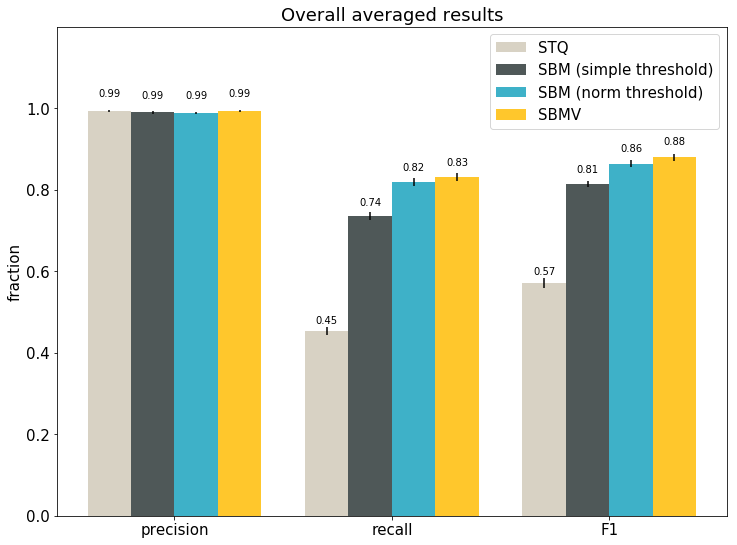

In [10]:
def autolabel(ax, rects):
    plt.rcParams.update({'font.size': 10})
    for rect in rects:
        height = rect.get_height()
        text = '{:.2f}'.format(height)
        text = re.sub('\.00$', '', text)
        ax.text(rect.get_x() + rect.get_width()/2., 1.03*height, text, ha='center', va='bottom')

ind = np.arange(3)
width = 0.2
plt.rcParams.update({'font.size': 15}) 
fig, ax = plt.subplots(figsize=(12, 9))

rects1 = ax.bar(ind - width, get_means(results_stq), width, color='#d8d2c4',
                yerr=get_ses(results_stq))
rects2 = ax.bar(ind, get_means(results_sbm_54), width, color='#4f5858',
                yerr=get_ses(results_sbm_54))
rects3 = ax.bar(ind + width, get_means(results_sbm_047), width, color='#3eb1c8',
                yerr=get_ses(results_sbm_047))
rects4 = ax.bar(ind + 2*width, get_means(results_sbmv_056), width, color='#ffc72c',
                yerr=get_ses(results_sbmv_056))

ax.set_ylabel('fraction')
ax.set_title('Overall averaged results')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('precision', 'recall', 'F1'))
plt.ylim(0, 1.2)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]),
          ('STQ', 'SBM (simple threshold)', 'SBM (norm threshold)', 'SBMV'))
autolabel(ax, rects1)
autolabel(ax, rects2)
autolabel(ax, rects3)
autolabel(ax, rects4)

plt.show()

All versions of SBM(V) outperform STQ in terms of F1, with a slightly worse precision and much better recall.

SBMV is the best algorithm, outperforming both STQ and SBM. SBMV's precision is very close to STQ's. At the same time, SBMV achieves recall almost twice as STQ's recall (83.09% vs. 45.35%). STQ's small recall suggests that STQ is very conservative and as a result, misses quite a few links.

I will also compare SBMV's and STQ's precisions, recalls and F1s for target documents using a paired Student's t-test. This will tell us whether the differences are statistically significant, or only the effect of sampling randomness.

In [11]:
results_docs_stq = results_stq.get(dfk.EVAL_DOC_METRICS)
results_docs_sbmv = results_sbmv_056.get(dfk.EVAL_DOC_METRICS)

for metric in ['precision', 'recall', 'F1']:
    _, p = ttest_rel(results_docs_stq[metric], results_docs_sbmv[metric])
    c = 'this is statistically significant' if p < 0.05 \
        else 'this is not statistically significant'
    print('{} p-value: {:.4f} ({})'.format(metric, p, c))

precision p-value: 0.9850 (this is not statistically significant)
recall p-value: 0.0000 (this is statistically significant)
F1 p-value: 0.0000 (this is statistically significant)


In each case, the test calculates the p-value. P-value is the probability of observing in our data the difference at least as big as we have, just by chance. P-value is typically compared to a predefined threshold (I used 5%) and based on this, we conclude the significance:
* If p-value is smaller than the threshold, it means it was very unlikely to observe the difference we have just by chance. In this case we conclude the difference is statistically significant.
* If p-value is larger than the threshold, it means it was more likely to observe the difference we have just by chance. In this case we conclude the difference is not statistically significant.

As we can see, the difference in precision between SBMV and STQ is not statistically significant, and the differences in recall and F1 are.

Finally, let's also compare precision, recall and F1 for each style separately.

In [12]:
def get_results_style(results, style):
    results = results.get(dfk.EVAL_SPLIT_METRICS)
    results = results.iloc[:,[7,8,9]][results['style'] == style]
    return list(results.to_records(index=False)[0])

styles = [['apa-noise', 'american-institute-of-physics-noise'],
          ['apa', 'chicago-author-date', 'modern-language-association'],
          ['american-chemical-society', 'american-institute-of-physics',
           'elsevier-without-titles'],
          ['degraded_all_authors', 'degraded_one_author', 'degraded_title_scrambled']]
titles = [['apa+noise', 'aip+noise'],
          ['apa', 'chicago', 'mla'],
          ['acs', 'aip', 'ewt'],
          ['degraded', 'one author', 'title scrambled']]

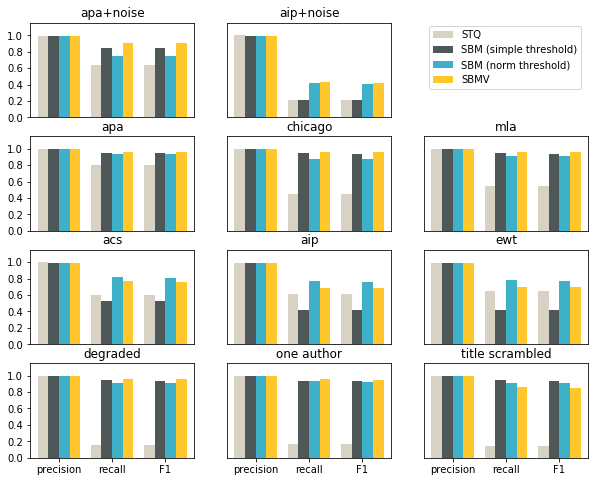

In [13]:
f, axes = plt.subplots(4, 3, sharex=True, sharey=True, figsize=(10, 8))
ind = np.arange(3)
width = 0.2

for i in range(4):
    for j in range(3):
        if len(styles) <= i or len(styles[i]) <= j:
            continue
        rects1 = axes[i, j].bar(ind-width, get_results_style(results_style_stq, styles[i][j]),
                                width, color='#d8d2c4')
        rects2 = axes[i, j].bar(ind, get_results_style(results_style_sbm_54, styles[i][j]),
                                width, color='#4f5858')
        rects3 = axes[i, j].bar(ind+width, get_results_style(results_style_sbm_047, styles[i][j]),
                                width, color='#3eb1c8')
        rects4 = axes[i, j].bar(ind+2*width,
                                get_results_style(results_style_sbmv_056, styles[i][j]), width,
                                color='#ffc72c')
        axes[i, j].set_title(titles[i][j])

axes[0, 0].set_xticks(ind + width / 2)
axes[0, 0].set_xticklabels(('precision', 'recall', 'F1'))
axes[0, 2].legend((rects1[0], rects2[0], rects3[0], rects4[0]),
                  ('STQ', 'SBM (simple threshold)', 'SBM (norm threshold)', 'SBMV'),
                  loc=3, bbox_to_anchor=(0, 0.25))

for i in range(3):
    for j in range(3):
        axes[i, j].xaxis.set_ticks_position('none') 
for i in range(4):
    for j in [1,2]:
        axes[i, j].yaxis.set_ticks_position('none')
axes[0, 2].axis('off')

plt.ylim(0, 1.15)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.show()

SBM with a simple threshold is worse than STQ for styles that do not include the title in the reference string (acs, aip, ewt). Both SBM with a normalized threshold and SBMV are in every case better than STQ.